### libraries

In [4]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes
from matplotlib.lines import Line2D
from imblearn.combine import SMOTEENN

In [1]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [2]:
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics
# Import libraries 
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# Import libraries
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz  

In [3]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [5]:
from xgboost import XGBClassifier

# Helper functions for model training

In [6]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    
    #dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    dataset_proba['propensity_logit'] = pd.DataFrame(np.nan_to_num(np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score'])),posinf=0,neginf=0))
    


In [7]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 1 - Load data sets 

In [8]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# PS estimation helper functions

In [9]:
def propensity_score_funct(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]

    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1]  # propensity score 

    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [10]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 2. Propensity score estimation

In [11]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### PS specs

In [12]:
ps_specification_logit_1 = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
ps_specification_logit_2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
ps_specification_logit_3 = ['treat','age','education*','black','hispanic','nodegree','black_age','married','re74','re75']
ps_specification_logit_4 = ['treat','age','education*','black','married','hispanic','married_u75','nodegree','re74','re75']

In [13]:
#['treat','age','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
markov_blanket_specification_1 = ['treat','age','education*','black','hispanic','married','nodegree','re75'] # CPS Lalonde sample 
markov_blanket_specification_2 = ['treat','age','education*','black','hispanic','married','nodegree','re75'] # PSID Lalonde sample 
markov_blanket_specification_3 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75'] # CPS Dehwab sample
markov_blanket_specification_4 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']  # PSID Dehwab and wahba sample 

In [14]:
annSpecification_1 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re75']  # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re75'] # PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

### model (1) Logistic Regression 

### Data

In [39]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[ps_specification_logit_1]
nswPsid_lalonde_subset = nswPsid_lalonde[ps_specification_logit_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[ps_specification_logit_3]
nswPsid_dehWab_subset = nswPsid_dehWab[ps_specification_logit_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

### Validation

In [40]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
		

	#Kfold training loop
	
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [41]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [42]:
# Model validation - K fold 
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [43]:
logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [44]:
logit1_metrics

,0,1,2,3,4,avg
Accuracy:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
Precision:,0.121348,0.130890,0.112360,0.129496,0.096552,0.118129
Recall:,0.900000,0.833333,0.847458,0.915254,0.949153,0.889040
MSE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
MAE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
R^2:,-5.740807,-4.806942,-5.973747,-5.352324,-8.096994,-5.994163
auc:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
roc_auc:,0.962044,0.947871,0.945158,0.959619,0.964756,0.955889
F1:,0.213861,0.226244,0.198413,0.226891,0.175274,0.208137
log-loss:,0.263571,0.241323,0.262708,0.270125,0.337827,0.275111


In [45]:
logit1.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [46]:
logit2_metrics

,0,1,2,3,4,avg
Accuracy:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
Precision:,0.481132,0.600000,0.521739,0.546392,0.467213,0.523295
Recall:,0.850000,0.900000,0.813559,0.898305,0.966102,0.885593
MSE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
MAE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
R^2:,-0.195181,0.215663,-0.042645,0.052141,-0.270131,-0.048031
auc:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
roc_auc:,0.960793,0.972122,0.951603,0.972262,0.974032,0.966162
F1:,0.614458,0.720000,0.635762,0.679487,0.629834,0.655908
log-loss:,0.250577,0.200025,0.241414,0.204177,0.283941,0.236027


In [47]:
logit2.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [48]:
logit3_metrics

,0,1,2,3,4,avg
Accuracy:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
Precision:,0.086486,0.084211,0.100977,0.089431,0.100559,0.092333
Recall:,0.864865,0.864865,0.837838,0.891892,0.972973,0.886486
MSE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
MAE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
R^2:,-8.377491,-8.650888,-6.709802,-8.295506,-7.830730,-7.972883
auc:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
roc_auc:,0.961863,0.948616,0.969677,0.953949,0.983055,0.963432
F1:,0.157248,0.153477,0.180233,0.162562,0.182278,0.167160
log-loss:,0.233103,0.260611,0.213819,0.247897,0.239693,0.239025


In [49]:
logit3.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)>

In [50]:
logit4_metrics

,0,1,2,3,4,avg
Accuracy:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
Precision:,0.450000,0.477612,0.468354,0.405063,0.468354,0.453877
Recall:,0.972973,0.864865,1.000000,0.864865,1.000000,0.940541
MSE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
MAE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
R^2:,-0.306578,-0.161402,-0.219472,-0.509823,-0.219472,-0.283350
auc:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
roc_auc:,0.983122,0.962254,0.982036,0.949256,0.986215,0.972577
F1:,0.615385,0.615385,0.637931,0.551724,0.637931,0.611671
log-loss:,0.192810,0.177873,0.200565,0.260109,0.206918,0.207655


In [51]:
logit4.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Inference

In [52]:
# Fit Logistic Regression using sklearn
# ======== Lalonde (1986) sample ======== #
logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid

LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [53]:
# Change logisistic regression to STAT's model implementation 

In [54]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_lalonde_subset,logit1,nswCps_lalonde,False)
nswPsid_lalonde_ps_LOGIT_withRe78= propensity_score_funct(nswPsid_lalonde_subset,logit2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_dehWab_subset,logit3,nswCps_dehWab,True)
nswPsid_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,logit4,nswPsid_dehWab,True)


# Export data

In [55]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT.csv')

### model (2) ; CART 

In [56]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

# CART - Feature selection

In [57]:
""" Select covariates for use in CART model - from GNN features """
# ======== Lalonde (1986) data ======== #
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation 

In [58]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [59]:
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()

grid_search_cart1 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 12,min_samples_leaf = 2)
grid_search_cart2 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 7,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart3 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart4 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)

In [60]:
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

<p> model evaluation </p>

In [61]:
cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [62]:
cart1_metrics

,0,1,2,3,4,avg
Accuracy:,0.832442,0.845356,0.810311,0.854594,0.885328,0.845607
Precision:,0.410000,0.341270,0.336283,0.273292,0.361538,0.344477
Recall:,0.683333,0.716667,0.644068,0.745763,0.796610,0.717288
MSE:,0.023941,0.030694,0.029466,0.040516,0.029168,0.030757
MAE:,0.023941,0.030694,0.029466,0.040516,0.029168,0.030757
R^2:,-0.324390,-0.697936,-0.657128,-1.278551,-0.639876,-0.719576
auc:,0.832442,0.845356,0.810311,0.854594,0.885328,0.845607
roc_auc:,0.923973,0.900409,0.919323,0.955050,0.956511,0.931053
F1:,0.512500,0.462366,0.441860,0.400000,0.497354,0.462816
log-loss:,0.170640,0.146979,0.145399,0.156483,0.159642,0.155829


In [63]:
cart2_metrics

,0,1,2,3,4,avg
Accuracy:,0.834839,0.893273,0.856698,0.923933,0.913331,0.884415
Precision:,0.529412,0.765625,0.582278,0.567010,0.478632,0.584592
Recall:,0.750000,0.816667,0.779661,0.932203,0.949153,0.845537
MSE:,0.098566,0.046595,0.082585,0.082585,0.114901,0.085047
MAE:,0.098566,0.046595,0.082585,0.082585,0.114901,0.085047
R^2:,-0.027108,0.514458,0.127970,0.127970,-0.213260,0.106006
auc:,0.834839,0.893273,0.856698,0.923933,0.913331,0.884415
roc_auc:,0.900770,0.938454,0.926758,0.951416,0.935403,0.930560
F1:,0.620690,0.790323,0.666667,0.705128,0.636364,0.683834
log-loss:,0.591851,0.292321,0.370720,0.206040,0.391955,0.370577


In [64]:
cart3_metrics

,0,1,2,3,4,avg
Accuracy:,0.891651,0.885399,0.865245,0.894305,0.922270,0.891774
Precision:,0.254237,0.189873,0.250000,0.297030,0.329897,0.264207
Recall:,0.810811,0.810811,0.756757,0.810811,0.864865,0.810811
MSE:,0.029357,0.041718,0.028748,0.024111,0.021638,0.029115
MAE:,0.029357,0.041718,0.028748,0.024111,0.021638,0.029115
R^2:,-1.597264,-2.690849,-1.542594,-1.132498,-0.913781,-1.575397
auc:,0.891651,0.885399,0.865245,0.894305,0.922270,0.891774
roc_auc:,0.941819,0.921631,0.925971,0.974351,0.974059,0.947566
F1:,0.387097,0.307692,0.375839,0.434783,0.477612,0.396605
log-loss:,0.108165,0.156694,0.101947,0.138785,0.106595,0.122437


In [65]:
cart4_metrics

,0,1,2,3,4,avg
Accuracy:,0.925866,0.911348,0.926870,0.885325,0.960925,0.922067
Precision:,0.622642,0.603774,0.634615,0.600000,0.744681,0.641142
Recall:,0.891892,0.864865,0.891892,0.810811,0.945946,0.881081
MSE:,0.044860,0.048598,0.042991,0.050467,0.026168,0.042617
MAE:,0.044860,0.048598,0.042991,0.050467,0.026168,0.042617
R^2:,0.303159,0.245088,0.332194,0.216053,0.593509,0.338001
auc:,0.925866,0.911348,0.926870,0.885325,0.960925,0.922067
roc_auc:,0.977206,0.949962,0.922148,0.872816,0.961033,0.936633
F1:,0.733333,0.711111,0.741573,0.689655,0.833333,0.741801
log-loss:,0.197654,0.281109,0.494797,0.677193,0.615881,0.453327


### Inference

In [66]:
nswCps_lalonde_ps_CART_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1,nswCps_lalonde,False)
nswPsid_lalonde_ps_CART_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3,nswCps_dehWab,True)
nswPsid_dehWab_ps_CART_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [67]:
nswCps_dehWab_ps_CART_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.912240,2.341300
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.076453,-2.491551
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.997103,5.841038
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.997103,5.841038
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.997103,5.841038
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22,12,1.0,0.0,0.0,0.0,3975,6801,2757,0.973103,3.588482
16173,0.0,20,12,1.0,0.0,1.0,0.0,1445,11832,6895,0.204762,-1.356794
16174,0.0,37,12,0.0,0.0,0.0,0.0,1733,1559,4221,0.076453,-2.491551
16175,0.0,47,9,0.0,0.0,1.0,1.0,16914,11384,13671,0.000000,-inf


In [68]:
# save unmatched CART datasets 
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART.csv')

### model (3) ; Random Forest

In [69]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [70]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

## Validation 

In [71]:
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()

grid_search_forest1 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest2 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest3 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'log2',min_samples_split = 3,n_estimators= 500)
grid_search_forest4 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'log2',min_samples_leaf = 2,n_estimators= 500)

In [72]:
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

In [73]:
forest1_metrics['avg'] = np.mean(forest1_metrics,axis=1)
forest2_metrics['avg'] = np.mean(forest2_metrics,axis=1)
forest3_metrics['avg'] = np.mean(forest3_metrics,axis=1)
forest4_metrics['avg'] = np.mean(forest4_metrics,axis=1)

In [74]:
forest1_metrics

,0,1,2,3,4,avg
Accuracy:,0.847858,0.839368,0.836986,0.859909,0.901808,0.857186
Precision:,0.390909,0.381818,0.379630,0.346457,0.362963,0.372355
Recall:,0.716667,0.700000,0.694915,0.745763,0.830508,0.737571
MSE:,0.025783,0.026397,0.026090,0.030080,0.029475,0.027565
MAE:,0.025783,0.026397,0.026090,0.030080,0.029475,0.027565
R^2:,-0.426266,-0.460225,-0.467249,-0.691652,-0.657137,-0.540506
auc:,0.847858,0.839368,0.836986,0.859909,0.901808,0.857186
roc_auc:,0.952304,0.963151,0.950233,0.967447,0.979754,0.962578
F1:,0.505882,0.494118,0.491018,0.473118,0.505155,0.493858
log-loss:,0.099698,0.086921,0.099486,0.108667,0.107807,0.100516


In [75]:
forest2_metrics


,0,1,2,3,4,avg
Accuracy:,0.854920,0.901606,0.861718,0.899632,0.927507,0.889077
Precision:,0.692308,0.769231,0.621622,0.675676,0.642857,0.680339
Recall:,0.750000,0.833333,0.779661,0.847458,0.915254,0.825141
MSE:,0.062724,0.044803,0.073609,0.059246,0.062837,0.060644
MAE:,0.062724,0.044803,0.073609,0.059246,0.062837,0.060644
R^2:,0.346386,0.533133,0.222755,0.374413,0.336499,0.362637
auc:,0.854920,0.901606,0.861718,0.899632,0.927507,0.889077
roc_auc:,0.957212,0.972624,0.949119,0.972415,0.973998,0.965073
F1:,0.720000,0.800000,0.691729,0.751880,0.755245,0.743771
log-loss:,0.183590,0.136694,0.226541,0.147691,0.199002,0.178703


In [76]:
forest3_metrics

,0,1,2,3,4,avg
Accuracy:,0.858926,0.896653,0.873063,0.886107,0.884700,0.879890
Precision:,0.415385,0.348837,0.451613,0.439394,0.386667,0.408379
Recall:,0.729730,0.810811,0.756757,0.783784,0.783784,0.772973
MSE:,0.014833,0.019468,0.013292,0.013910,0.016692,0.015639
MAE:,0.014833,0.019468,0.013292,0.013910,0.016692,0.015639
R^2:,-0.312302,-0.722396,-0.175608,-0.230288,-0.476345,-0.383388
auc:,0.858926,0.896653,0.873063,0.886107,0.884700,0.879890
roc_auc:,0.981147,0.958682,0.987323,0.951807,0.987272,0.973246
F1:,0.529412,0.487805,0.565657,0.563107,0.517857,0.532767
log-loss:,0.054264,0.078685,0.042838,0.068835,0.054201,0.059765


In [77]:
forest4_metrics

,0,1,2,3,4,avg
Accuracy:,0.915364,0.893357,0.913356,0.871812,0.963937,0.911565
Precision:,0.653061,0.714286,0.627451,0.591837,0.795455,0.676418
Recall:,0.864865,0.810811,0.864865,0.783784,0.945946,0.854054
MSE:,0.041121,0.035514,0.044860,0.052336,0.020561,0.038879
MAE:,0.041121,0.035514,0.044860,0.052336,0.020561,0.038879
R^2:,0.361229,0.448334,0.303159,0.187018,0.680614,0.396071
auc:,0.915364,0.893357,0.913356,0.871812,0.963937,0.911565
roc_auc:,0.985455,0.948361,0.988929,0.927602,0.992076,0.968485
F1:,0.744186,0.759494,0.727273,0.674419,0.864198,0.753914
log-loss:,0.093115,0.236380,0.116048,0.279498,0.093278,0.163664


### Inference

In [78]:
#  Lalonde Subsample 
nswCps_lalonde_ps_FOREST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1,nswCps_lalonde,False)
nswPsid_lalonde_ps_FOREST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [79]:
nswCps_dehWab_ps_FOREST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.956815,3.098118
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.256097,-1.066356
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.992915,4.942696
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.998019,6.222056
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.997883,6.155765
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22,12,1.0,0.0,0.0,0.0,3975,6801,2757,0.734764,1.018929
16173,0.0,20,12,1.0,0.0,1.0,0.0,1445,11832,6895,0.011786,-4.428956
16174,0.0,37,12,0.0,0.0,0.0,0.0,1733,1559,4221,0.013020,-4.328185
16175,0.0,47,9,0.0,0.0,1.0,1.0,16914,11384,13671,0.000000,-inf


In [80]:
# save unmatched logit datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST.csv')

### model (4) ; Boosted Trees

In [81]:
""" Select covariates for use in BOOST model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



## Validation 

In [82]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()
    

# models 
grid_search_boost1 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost2 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost3 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 1,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost4 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 

In [83]:
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

In [84]:
boost1_metrics['avg'] = np.mean(boost1_metrics,axis=1)
boost2_metrics['avg'] = np.mean(boost2_metrics,axis=1)
boost3_metrics['avg'] = np.mean(boost3_metrics,axis=1)
boost4_metrics['avg'] = np.mean(boost4_metrics,axis=1)

In [85]:
boost1_metrics

,0,1,2,3,4,avg
Accuracy:,0.842902,0.876188,0.833929,0.827330,0.911285,0.858327
Precision:,0.224490,0.321918,0.180672,0.186667,0.216667,0.226083
Recall:,0.733333,0.783333,0.728814,0.711864,0.881356,0.767740
MSE:,0.051565,0.034377,0.064764,0.061387,0.059871,0.054393
MAE:,0.051565,0.034377,0.064764,0.061387,0.059871,0.054393
R^2:,-1.852533,-0.901689,-2.642229,-2.452350,-2.366060,-2.042972
auc:,0.842902,0.876188,0.833929,0.827330,0.911285,0.858327
roc_auc:,0.958307,0.955571,0.944588,0.958454,0.978003,0.958985
F1:,0.343750,0.456311,0.289562,0.295775,0.347826,0.346645
log-loss:,0.137953,0.115952,0.151412,0.150611,0.151692,0.141524


In [86]:
boost2_metrics

,0,1,2,3,4,avg
Accuracy:,0.863554,0.891265,0.867181,0.907103,0.929957,0.891812
Precision:,0.626667,0.742424,0.602564,0.671053,0.604396,0.649421
Recall:,0.783333,0.816667,0.796610,0.864407,0.932203,0.838644
MSE:,0.073477,0.050179,0.077199,0.059246,0.071813,0.066383
MAE:,0.073477,0.050179,0.077199,0.059246,0.071813,0.066383
R^2:,0.234337,0.477108,0.184841,0.374413,0.241713,0.302482
auc:,0.863554,0.891265,0.867181,0.907103,0.929957,0.891812
roc_auc:,0.956677,0.967102,0.953032,0.973215,0.976210,0.965247
F1:,0.696296,0.777778,0.686131,0.755556,0.733333,0.729819
log-loss:,0.185442,0.149284,0.208083,0.152082,0.193424,0.177663


In [87]:
boost3_metrics

,0,1,2,3,4,avg
Accuracy:,0.893527,0.888994,0.892741,0.901095,0.920550,0.899381
Precision:,0.283019,0.222222,0.270270,0.213793,0.296296,0.257120
Recall:,0.810811,0.810811,0.810811,0.837838,0.864865,0.827027
MSE:,0.025649,0.034611,0.027202,0.037094,0.025039,0.029919
MAE:,0.025649,0.034611,0.027202,0.037094,0.025039,0.029919
R^2:,-1.269189,-2.062038,-1.405896,-2.280767,-1.214518,-1.646481
auc:,0.893527,0.888994,0.892741,0.901095,0.920550,0.899381
roc_auc:,0.978515,0.954580,0.978483,0.960955,0.984915,0.971490
F1:,0.419580,0.348837,0.405405,0.340659,0.441379,0.391172
log-loss:,0.095889,0.103251,0.091482,0.105370,0.091240,0.097446


In [88]:
boost4_metrics

,0,1,2,3,4,avg
Accuracy:,0.928878,0.915364,0.922854,0.903316,0.973434,0.928769
Precision:,0.660000,0.653061,0.589286,0.524590,0.734694,0.632326
Recall:,0.891892,0.864865,0.891892,0.864865,0.972973,0.897297
MSE:,0.039252,0.041121,0.050467,0.063551,0.026168,0.044112
MAE:,0.039252,0.041121,0.050467,0.063551,0.026168,0.044112
R^2:,0.390264,0.361229,0.216053,0.012808,0.593509,0.314773
auc:,0.928878,0.915364,0.922854,0.903316,0.973434,0.928769
roc_auc:,0.983990,0.971236,0.986161,0.944236,0.989987,0.975122
F1:,0.758621,0.744186,0.709677,0.653061,0.837209,0.740551
log-loss:,0.117582,0.127595,0.131927,0.186513,0.114955,0.135714


### Inference

In [89]:
#  Lalonde Subsample 
nswCps_lalonde_ps_BOOST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_boost1,nswCps_lalonde,False)
nswPsid_lalonde_ps_BOOST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_boost2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [90]:
# save unmatched boost datasets 
nswCps_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_lalonde_ps_unmatched_BOOST.csv')
nswPsid_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_lalonde_ps_unmatched_BOOST.csv')
nswCps_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_dehWab_ps_unmatched_BOOST.csv')
nswPsid_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_dehWab_ps_unmatched_BOOST.csv')

In [91]:
nswPsid_lalonde_ps_BOOST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,9930,0.708737,0.889260
1,1.0,22,9,0.0,1.0,0.0,1.0,0,3595,0.899089,2.187143
2,1.0,30,12,1.0,0.0,0.0,0.0,0,24909,0.832788,1.605514
3,1.0,27,11,1.0,0.0,0.0,1.0,0,7506,0.970240,3.484376
4,1.0,33,8,1.0,0.0,0.0,1.0,0,289,0.896335,2.157150
...,...,...,...,...,...,...,...,...,...,...,...
2782,0.0,47,8,0.0,0.0,1.0,1.0,33837,38568,0.013073,-4.324068
2783,0.0,32,8,0.0,0.0,1.0,1.0,67137,59109,0.022543,-3.769539
2784,0.0,47,10,0.0,0.0,1.0,1.0,47968,55710,0.015343,-4.161638
2785,0.0,54,0,0.0,1.0,1.0,1.0,44220,20540,0.025119,-3.658675


### model (5) - artifical neural network

In [16]:
# Import libraries 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  DataLoader,SubsetRandomSampler 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN


In [17]:
annSpecification_1 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re75']  # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re75'] # PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

In [18]:
resample=SMOTEENN(random_state=0)
sm = SMOTE(random_state=0)

In [19]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [20]:
# ANN data pre-processing
# Select covariates 
# ======== Lalonde (1986) data ======== #


nswCps_lalonde_subset = nswCps_lalonde[annSpecification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[annSpecification_2]

# Z-score normalise continous variables
sc = MinMaxScaler()

nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
#nswPsid_lalonde_subset[nsw_continuos_vars2] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars2])

nswCps_lalonde_subset = nswCps_lalonde_subset.sample(frac=1).reset_index(drop=True)
nswPsid_lalonde_subset = nswPsid_lalonde_subset.sample(frac=1).reset_index(drop=True)

# Create targets and featues
nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #


nswCps_dehWab_subset = nswCps_dehWab[annSpecification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[annSpecification_4]

nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
nswPsid_dehWab_subset[nswre74_continuos_vars2] = sc.fit_transform(nswPsid_dehWab_subset[nswre74_continuos_vars2])

nswCps_dehWab_subset = nswCps_dehWab_subset.sample(frac=1).reset_index(drop=True)
nswPsid_dehWab_subset = nswPsid_dehWab_subset.sample(frac=1).reset_index(drop=True)

# create targets and features 
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_68455/3854445176.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_68455/3854445176.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd

### Inference

<p> Neural network </p>

In [21]:
# ANN model 
hid_1 = 100
hid_2 = 100

class twoLayerNN1(nn.Module):
    def __init__(self,num_features = nswCps_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
       
        super(twoLayerNN1, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        #self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X

class twoLayerNN2(nn.Module):
    def __init__(self,num_features = nswPsid_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN3(nn.Module):
    def __init__(self,num_features = nswCps_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN3, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
       # X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN4(nn.Module):
    def __init__(self,num_features = nswPsid_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
        super(twoLayerNN4, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       
   


### Model validation

In [22]:
from skorch import NeuralNetClassifier
Epochs = 100
learning_rate = 0.0001
weight_decay = 0.1
batch_size = 1000

ANN1 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False)
ANN2 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN3 = NeuralNetClassifier(twoLayerNN3,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN4 = NeuralNetClassifier(twoLayerNN4,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False  )
                                                  
            

In [23]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation_ANN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['logloss:', fold] =  metrics.log_loss(y_test, prediction_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)

		X_train , X_test, y_train , y_test = features[train_index],features[test_index],\
												target[train_index] , target[test_index]
		
		print('Xtrain pre augmentation:',X_train.shape)
		print('Ytrain pre augmentation',y_train.shape) 

		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
        #resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		X_train = X_train.to_numpy()
		y_train = y_train.to_numpy()
		X_train = X_train.astype(np.float32)
		y_train = y_train.astype(np.float32)
		y_train = np.reshape(y_train,(y_train.shape[0],1))

		print('Xtrain:',X_train.shape)
		print('Ytrain',y_train.shape)	
		print('Xtest',X_test.shape)	
		print('Ytest',y_test.shape)	
									 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


### Training and Validation

In [32]:
# Conver features and targets to numpy arrays then floats to feed to ANN
X1 = nswCps_lalonde_features.to_numpy()
Y1 = nswCps_lalonde_target.to_numpy()
X1 = X1.astype(np.float32)
Y1 = Y1.astype(np.float32)
Y1 = np.reshape(Y1,(Y1.shape[0],1))

# ~ ~ ~
X2 = nswPsid_lalonde_features.to_numpy()
Y2 = nswPsid_lalonde_target.to_numpy()
X2 = X2.astype(np.float32)
Y2 = Y2.astype(np.float32)
Y2 = np.reshape(Y2,(Y2.shape[0],1))
# ~ ~ ~
X3 = nswCps_dehWab_features.to_numpy()
Y3 = nswCps_dehWab_target.to_numpy()
X3 = X3.astype(np.float32)
Y3 = Y3.astype(np.float32)
Y3 = np.reshape(Y3,(Y3.shape[0],1))
# ~ ~ ~
X4 = nswPsid_dehWab_features.to_numpy()
Y4 = nswPsid_dehWab_target.to_numpy()
X4 = X4.astype(np.float32)
Y4 = Y4.astype(np.float32)
Y4 = np.reshape(Y4,(Y4.shape[0],1))

In [10]:
# ANN 1  - Lalonde CPS 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()

kfold_evaluation_ANN(ANN1,X1,Y1,ANN1_metrics)
kfold_evaluation_ANN(ANN2,X2,Y2,ANN2_metrics)
kfold_evaluation_ANN(ANN3,X3,Y3,ANN3_metrics)
kfold_evaluation_ANN(ANN4,X4,Y4,ANN4_metrics)

Xtrain pre augmentation: (13031, 7)
Ytrain pre augmentation (13031, 1)
Xtrain: (24259, 7)
Ytrain (24259, 1)
Xtest (3258, 7)
Ytest (3258, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8041       0.5027        0.7273  0.4016
      2        0.7861       0.5027        0.7589  0.2437
      3        0.7688       0.5027        0.7594  0.2409
      4        0.7521       0.5027        0.7455  0.2382
      5        0.7359       0.5027        0.7297  0.2434
      6        0.7203       0.5027        0.7145  0.2406
      7        0.7052       0.5027        0.6998  0.2347
      8        0.6906       0.5027        0.6854  0.2364
      9        0.6765       0.5027        0.6715  0.2347
     10        0.6628       0.5027        0.6580  0.2334
     11        0.6495       0.5027        0.6449  0.2372
     12        0.6366       0.5027        0.6321  0.2365
     13        0.6240       0.5027        0.6197  0.2341
     

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24399, 7)
Ytrain (24399, 1)
Xtest (3258, 7)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7703       0.5020        0.7088  0.4003
      2        0.7560       0.5020        0.7339  0.3207
      3        0.7427       0.5020        0.7354  0.3260
      4        0.7300       0.5020        0.7252  0.3078
      5        0.7177       0.5020        0.7142  0.3263
      6        0.7056       0.5020        0.7029  0.3097
      7        0.6937       0.5020        0.6917  0.3003
      8        0.6813       0.5020        0.6801  0.2936
      9        0.6687       0.5020        0.6687  0.3186
     10        0.6569       0.5020        0.6580  0.2674
     11        0.6462       0.5020        0.6481  0.2806
     12        0.6361       0.5020        0.6387  0.2815
     13        0.6266       0.5020        0.6297  0.333

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24235, 7)
Ytrain (24235, 1)
Xtest (3258, 7)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7284       0.5053        0.6888  0.2602
      2        0.7075       0.5053        0.6780  0.3449
      3        0.6883       0.5053        0.6724  0.2604
      4        0.6709       0.5053        0.6592  0.2666
      5        0.6550       0.5053        0.6450  0.2634
      6        0.6404       0.5053        0.6316  0.2622
      7        0.6269       0.5053        0.6192  0.2593
      8        0.6145       0.5053        0.6074  0.2612
      9        0.6029       0.5053        0.5961  0.2638
     10        0.5919       0.5053        0.5855  0.2632
     11        0.5814       0.5053        0.5754  0.2596
     12        0.5716       0.5053        0.5659  0.2610
     13        0.5623       0.5053        0.5569  0.266

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24207, 7)
Ytrain (24207, 1)
Xtest (3258, 7)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7264       0.5025        0.6989  0.3581
      2        0.7109       0.5025        0.6664  0.3565
      3        0.6958       0.5025        0.6564  0.3195
      4        0.6804       0.5025        0.6619  0.3697
      5        0.6638       0.5025        0.6623  0.2585
      6        0.6517       0.5025        0.6556  0.2585
      7        0.6419       0.5025        0.6467  0.3037
      8        0.6325       0.5025        0.6377  0.2886
      9        0.6235       0.5025        0.6290  0.2610
     10        0.6149       0.5025        0.6207  0.2596
     11        0.6068       0.5025        0.6129  0.2627
     12        0.5992       0.5025        0.6055  0.2610
     13        0.5920       0.5025        0.5984  0.273

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24342, 7)
Ytrain (24342, 1)
Xtest (3257, 7)
Ytest (3257, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5401       0.5022        0.6249  0.2488
      2        0.5340       0.5022        0.5578  0.2496
      3        0.5282       0.5022        0.5348  0.2562
      4        0.5227       0.5022        0.5281  0.2522
      5        0.5174       0.5022        0.5233  0.3238
      6        0.5123       0.5022        0.5187  0.2498
      7        0.5073       0.5022        0.5140  0.2507
      8        0.5025       0.5022        0.5094  0.2497
      9        0.4977       0.5022        0.5049  0.2544
     10        0.4931       0.5022        0.5005  0.2522
     11        0.4886       0.5022        0.4962  0.2516
     12        0.4841       0.5022        0.4920  0.2594
     13        0.4798       0.5022        0.4879  0.253

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.5179       0.5176        0.6543  0.0449
      5        0.5152       0.5176        0.6415  0.0432
      6        0.5126       0.5176        0.6282  0.0449
      7        0.5100       0.5176        0.6146  0.0467
      8        0.5070       0.5176        0.6010  0.0438
      9        0.5038       0.5176        0.5874  0.0435
     10        0.5008       0.5176        0.5738  0.0416
     11        0.4980       0.5176        0.5605  0.0462
     12        0.4954       0.5176        0.5479  0.0431
     13        0.4930       0.5176        0.5363  0.0447
     14        0.4907       0.5176        0.5258  0.0416
     15        0.4885       0.5176        0.5167  0.0457
     16        0.4865       0.5176        0.5086  0.0426
     17        0.4845       0.5176        0.5015  0.0442
     18        0.4826       0.5176        0.4952  0.0439
     19        0.4808       0.5176        0.4898  0.0435
     20        0.4790       0.5176        0.4852  0.0430
     21        0.4773       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.5384       0.5168        0.6256  0.0538
      5        0.5344       0.5168        0.6119  0.0433
      6        0.5320       0.5168        0.5982  0.0439
      7        0.5298       0.5168        0.5846  0.0447
      8        0.5278       0.5168        0.5715  0.0431
      9        0.5257       0.5168        0.5591  0.0445
     10        0.5238       0.5168        0.5475  0.0451
     11        0.5219       0.5168        0.5371  0.0499
     12        0.5200       0.5168        0.5278  0.0451
     13        0.5182       0.5168        0.5198  0.0469
     14        0.5164       0.5168        0.5129  0.0431
     15        0.5147       0.5168        0.5071  0.0414
     16        0.5130       0.5168        0.5023  0.0432
     17        0.5114       0.5168        0.4984  0.0453
     18        0.5098       0.5168        0.4952  0.0423
     19        0.5082       0.5168        0.4925  0.0455
     20        0.5067       0.5168        0.4902  0.0461
     21        0.5052       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.9061       0.5189        0.6559  0.0486
      3        0.8693       0.5189        0.6667  0.0452
      4        0.7845       0.5189        0.6804  0.0442
      5        0.7772       0.5189        0.6923  0.0426
      6        0.7702       0.5189        0.7028  0.0441
      7        0.7635       0.5189        0.7125  0.0448
      8        0.7570       0.5189        0.7216  0.0445
      9        0.7508       0.5189        0.7299  0.0439
     10        0.7447       0.5189        0.7370  0.0448
     11        0.7388       0.5189        0.7425  0.0429
     12        0.7331       0.5189        0.7462  0.0431
     13        0.7275       0.5189        0.7484  0.0439
     14        0.7221       0.5189        0.7488  0.0442
     15        0.7169       0.5189        0.7476  0.0463
     16        0.7117       0.5189        0.7450  0.0445
     17        0.7067       0.5189        0.7413  0.0455
     18        0.7018       0.5189        0.7367  0.0465
     19        0.6970       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2457: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


      4        0.7140       0.5227        0.7337  0.0481
      5        0.7076       0.5227        0.7224  0.0466
      6        0.7015       0.5227        0.7126  0.0452
      7        0.6957       0.5227        0.7038  0.0446
      8        0.6902       0.5227        0.6956  0.0474
      9        0.6849       0.5227        0.6879  0.0450
     10        0.6798       0.5227        0.6807  0.0447
     11        0.6748       0.5227        0.6742  0.0437
     12        0.6699       0.5227        0.6680  0.0451
     13        0.6652       0.5227        0.6623  0.0457
     14        0.6606       0.5227        0.6572  0.0427
     15        0.6562       0.5227        0.6522  0.0476
     16        0.6518       0.5227        0.6474  0.0499
     17        0.6476       0.5227        0.6429  0.0443
     18        0.6434       0.5227        0.6386  0.0423
     19        0.6394       0.5227        0.6345  0.0498
     20        0.6355       0.5227        0.6305  0.0428
     21        0.6316       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.8808       0.5142        0.7233  0.0530
      4        0.8684       0.5142        0.7253  0.0565
      5        0.8573       0.5142        0.7283  0.0587
      6        0.8471       0.5142        0.7314  0.0545
      7        0.8371       0.5142        0.7347  0.0595
      8        0.8268       0.5142        0.7376  0.0603
      9        0.8152       0.5142        0.7385  0.0558
     10        0.8191       0.5142        0.9010  0.0588
     11        0.8311       0.5142        0.8456  0.0589
     12        0.8198       0.5142        0.8210  0.0567
     13        0.8085       0.5142        0.8066  0.0553
     14        0.7970       0.5142        0.7956  0.0550
     15        0.7851       0.5142        0.7852  0.1211
     16        0.7728       0.5142        0.7745  0.0586
     17        0.7596       0.5142        0.7630  0.0509
     18        0.7450       0.5142        0.7503  0.0566
     19        0.7294       0.5142        0.7370  0.0539
     20        0.7147       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19298, 8)
Ytrain (19298, 1)
Xtest (3236, 8)
Ytest (3236, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6180       0.4777        0.6313  0.2394
      2        0.5697       0.4777        0.5918  0.2299
      3        0.5455       0.4777        0.5513  0.2355
      4        0.5272       0.4777        0.5249  0.2291
      5        0.5097       0.4777        0.5074  0.2271
      6        0.4932       0.4777        0.4952  0.2331
      7        0.4800       0.4777        0.4848  0.2316
      8        0.4685       0.4777        0.4748  0.2317
      9        0.4577       0.4777        0.4650  0.2308
     10        0.4472       0.4777        0.4550  0.2388
     11        0.4368       0.4777        0.4455  0.2349
     12        0.4275       0.4777        0.4372  0.2355
     13        0.4197       0.4777        0.4304  0.2287
     14        0.4132       0.4777        0.4247  0.2289
     15        0.40

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19595, 8)
Ytrain (19595, 1)
Xtest (3236, 8)
Ytest (3236, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7892       0.4741        0.7320  0.2140
      2        0.7370       0.4741        0.7253  0.3008
      3        0.6918       0.4741        0.6857  0.2211
      4        0.6642       0.4741        0.6493  0.2224
      5        0.6411       0.4741        0.6248  0.2229
      6        0.6213       0.4741        0.6075  0.2212
      7        0.6039       0.4741        0.5920  0.2273
      8        0.5881       0.4741        0.5775  0.2191
      9        0.5736       0.4741        0.5642  0.2170
     10        0.5602       0.4741        0.5518  0.2186
     11        0.5479       0.4741        0.5403  0.2226
     12        0.5366       0.4741        0.5297  0.2292
     13        0.5262       0.4741        0.5200  0.220

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19736, 8)
Ytrain (19736, 1)
Xtest (3235, 8)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8159       0.4734        0.7771  0.2104
      2        0.7571       0.4734        0.7578  0.2377
      3        0.7091       0.4734        0.7010  0.2136
      4        0.6718       0.4734        0.6578  0.2146
      5        0.6452       0.4734        0.6310  0.2147
      6        0.6241       0.4734        0.6118  0.2148
      7        0.6065       0.4734        0.5961  0.2145
      8        0.5911       0.4734        0.5822  0.2183
      9        0.5773       0.4734        0.5692  0.2180
     10        0.5647       0.4734        0.5572  0.2965
     11        0.5530       0.4734        0.5461  0.2157
     12        0.5423       0.4734        0.5357  0.2194
     13        0.5321       0.4734        0.5257  0.218

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19169, 8)
Ytrain (19169, 1)
Xtest (3235, 8)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7005       0.4765        0.6794  0.2152
      2        0.6718       0.4765        0.6899  0.2205
      3        0.6467       0.4765        0.6605  0.2260
      4        0.6211       0.4765        0.6155  0.2448
      5        0.5985       0.4765        0.5897  0.2183
      6        0.5819       0.4765        0.5723  0.2198
      7        0.5668       0.4765        0.5581  0.2200
      8        0.5531       0.4765        0.5460  0.2392
      9        0.5411       0.4765        0.5353  0.2169
     10        0.5300       0.4765        0.5253  0.2185
     11        0.5196       0.4765        0.5160  0.3054
     12        0.5099       0.4765        0.5072  0.2186
     13        0.5008       0.4765        0.4991  0.218

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19727, 8)
Ytrain (19727, 1)
Xtest (3235, 8)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5565       0.4691        0.6080  0.2169
      2        0.5256       0.4691        0.5451  0.2276
      3        0.5022       0.4691        0.4987  0.2219
      4        0.4836       0.4691        0.4737  0.2243
      5        0.4684       0.4691        0.4602  0.2239
      6        0.4555       0.4691        0.4495  0.3057
      7        0.4441       0.4691        0.4397  0.2307
      8        0.4341       0.4691        0.4308  0.2236
      9        0.4251       0.4691        0.4226  0.2228
     10        0.4170       0.4691        0.4153  0.2371
     11        0.4098       0.4691        0.4087  0.2247
     12        0.4033       0.4691        0.4027  0.2227
     13        0.3974       0.4691        0.3972  0.224

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.6160       0.4913        0.6851  0.0757
      4        0.6123       0.4913        0.6803  0.0702
      5        0.6089       0.4913        0.6773  0.0724
      6        0.6058       0.4913        0.6750  0.0701
      7        0.6030       0.4913        0.6728  0.0600
      8        0.6002       0.4913        0.6707  0.0580
      9        0.5977       0.4913        0.6675  0.0684
     10        0.5952       0.4913        0.6626  0.0688
     11        0.5928       0.4913        0.6560  0.0741
     12        0.5905       0.4913        0.6482  0.0615
     13        0.5882       0.4913        0.6395  0.0668
     14        0.5859       0.4913        0.6307  0.0574
     15        0.5835       0.4913        0.6218  0.0576
     16        0.5810       0.4913        0.6130  0.0561
     17        0.5785       0.4913        0.6044  0.1232
     18        0.5760       0.4913        0.5965  0.0711
     19        0.5737       0.4913        0.5894  0.0593
     20        0.5715       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2457: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


      2        0.6736       0.4934        0.6912  0.0642
      3        0.6713       0.4934        0.6741  0.0593
      4        0.6689       0.4934        0.6555  0.0568
      5        0.6669       0.4934        0.6393  0.0569
      6        0.6648       0.4934        0.6263  0.0564
      7        0.6618       0.4934        0.6174  0.0646
      8        0.6598       0.4934        0.6128  0.0708
      9        0.6577       0.4934        0.6102  0.0595
     10        0.6556       0.4934        0.6089  0.0624
     11        0.6536       0.4934        0.6085  0.0672
     12        0.6516       0.4934        0.6083  0.0632
     13        0.6496       0.4934        0.6080  0.0653
     14        0.6476       0.4934        0.6074  0.0627
     15        0.6456       0.4934        0.6064  0.0679
     16        0.6436       0.4934        0.6059  0.0622
     17        0.6416       0.4934        0.6053  0.0623
     18        0.6396       0.4934        0.6051  0.0693
     19        0.6374       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.7244       0.4946        0.6973  0.0591
      4        0.7220       0.4946        0.6970  0.0688
      5        0.7196       0.4946        0.6981  0.0722
      6        0.7172       0.4946        0.7004  0.0691
      7        0.7149       0.4946        0.7023  0.0611
      8        0.7125       0.4946        0.7052  0.0537
      9        0.7102       0.4946        0.7072  0.0534
     10        0.7079       0.4946        0.7079  0.0564
     11        0.7056       0.4946        0.7079  0.0540
     12        0.7033       0.4946        0.7075  0.0534
     13        0.7010       0.4946        0.7068  0.0525
     14        0.6987       0.4946        0.7055  0.0541
     15        0.6964       0.4946        0.7037  0.0565
     16        0.6941       0.4946        0.7016  0.0526
     17        0.6919       0.4946        0.6993  0.0524
     18        0.6896       0.4946        0.6968  0.0517
     19        0.6874       0.4946        0.6941  0.0539
     20        0.6852       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.7520       0.4980        0.6956  0.0673
      4        0.7490       0.4980        0.6978  0.0601
      5        0.7460       0.4980        0.6988  0.0594
      6        0.7431       0.4980        0.6994  0.0632
      7        0.7402       0.4980        0.6997  0.0636
      8        0.7374       0.4980        0.7008  0.0707
      9        0.7347       0.4980        0.7034  0.0570
     10        0.7321       0.4980        0.7061  0.0548
     11        0.7296       0.4980        0.7088  0.0670
     12        0.7271       0.4980        0.7114  0.0601
     13        0.7247       0.4980        0.7135  0.0619
     14        0.7223       0.4980        0.7150  0.0586
     15        0.7199       0.4980        0.7157  0.0662
     16        0.7176       0.4980        0.7158  0.0606
     17        0.7153       0.4980        0.7152  0.0642
     18        0.7130       0.4980        0.7142  0.0615
     19        0.7107       0.4980        0.7128  0.0619
     20        0.7085       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.7763       0.4938        0.7582  0.0529
      4        0.7734       0.4938        0.7638  0.0542
      5        0.7706       0.4938        0.7681  0.0511
      6        0.7677       0.4938        0.7711  0.0510
      7        0.7645       0.4938        0.7731  0.0522
      8        0.7598       0.4938        0.7739  0.0564
      9        0.7548       0.4938        0.7738  0.0499
     10        0.7516       0.4938        0.7728  0.0538
     11        0.7491       0.4938        0.7714  0.0515
     12        0.7468       0.4938        0.7692  0.1165
     13        0.7444       0.4938        0.7665  0.0503
     14        0.7420       0.4938        0.7635  0.0565
     15        0.7397       0.4938        0.7603  0.0540
     16        0.7374       0.4938        0.7569  0.0529
     17        0.7351       0.4938        0.7534  0.0520
     18        0.7328       0.4938        0.7500  0.0536
     19        0.7306       0.4938        0.7466  0.0530
     20        0.7282       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
ANN1_metrics.replace(np.inf, 0, inplace=True)
ANN2_metrics.replace(np.inf, 0, inplace=True)
ANN3_metrics.replace(np.inf, 0, inplace=True)
ANN4_metrics.replace(np.inf, 0, inplace=True)
ANN1_metrics['avg'] = np.mean(ANN1_metrics,axis=1)
ANN2_metrics['avg'] = np.mean(ANN2_metrics,axis=1)
ANN3_metrics['avg'] = np.mean(ANN3_metrics,axis=1)
ANN4_metrics['avg'] = np.mean(ANN4_metrics,axis=1)

In [13]:

ANN1_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
MAE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
R^2:,-0.018443,-0.018443,-0.018762,-0.018762,-0.018449,-0.018572
roc_auc:,0.962223,0.960684,0.943431,0.949953,0.957341,0.954726
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.331176,0.375470,0.341646,0.382937,0.358055,0.357857


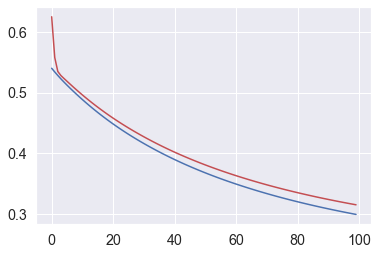

In [14]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [15]:
ANN2_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
MAE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
R^2:,-0.120482,-0.120482,-0.118474,-0.118474,-0.118474,-0.119277
roc_auc:,0.914960,0.872992,0.884113,0.898271,0.877119,0.889491
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.488569,0.486464,0.000000,0.517675,0.529648,0.404471


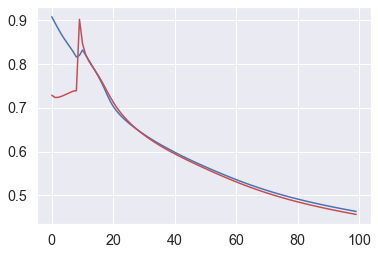

In [16]:
from turtle import color
history = ANN2.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [17]:
ANN3_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
MAE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
R^2:,-0.011566,-0.011566,-0.011570,-0.011570,-0.011570,-0.011568
roc_auc:,0.880617,0.933062,0.890434,0.920373,0.891436,0.903184
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.387103,0.365544,0.407094,0.392567,0.357758,0.382013


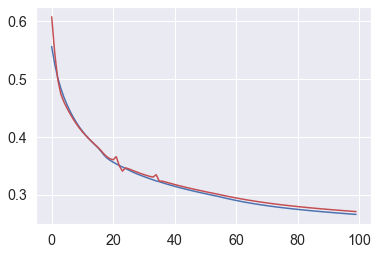

In [18]:
from turtle import color
history = ANN3.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [19]:
ANN4_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
MAE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
R^2:,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297
roc_auc:,0.893330,0.783133,0.839954,0.918919,0.911592,0.869386
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.000000,0.628636,0.585330,0.630772,0.617690,0.492486


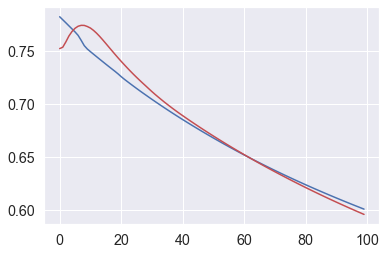

In [20]:
from turtle import color
history = ANN4.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

## Inference

In [21]:
def propensity_score_functANN(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]
    columns = dataset.columns
    dataset = dataset.to_numpy()
    dataset = dataset.astype(np.float32)
    #Y1 = np.reshape(Y1,(Y1.shape[0],1))
    # Generate propensity score prediction  
    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities # propensity score 
    # merge prediction and existing dataset 
    dataset = pd.DataFrame(dataset)
    dataset.columns = columns
    #dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [22]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_ANN = propensity_score_functANN(nswCps_lalonde_subset,ANN1,nswCps_lalonde,False)
nswPsid_lalonde_ps_ANN= propensity_score_functANN(nswPsid_lalonde_subset,ANN2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_ANN = propensity_score_functANN(nswCps_dehWab_subset,ANN3,nswCps_dehWab,True)
nswPsid_dehWab_ps_ANN = propensity_score_functANN(nswPsid_dehWab_subset,ANN4,nswPsid_dehWab,True)

In [23]:
# save unmatched boost datasets 
nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN.csv')
nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN.csv')
nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN.csv')
nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN.csv')

## Bar plots of model performance

In [92]:
# Average accuracy
from tueplots import axes, bundles , figsizes, fonts,fontsizes
nsw_cps_lalonde_acc = [ANN1_metrics.loc['Accuracy:','avg'],boost1_metrics.loc['Accuracy:','avg'],forest1_metrics.loc['Accuracy:','avg'],cart1_metrics.loc['Accuracy:','avg'],logit1_metrics.loc['Accuracy:','avg']]
nsw_psid_lalonde_acc = [ANN2_metrics.loc['Accuracy:','avg'],boost2_metrics.loc['Accuracy:','avg'],forest2_metrics.loc['Accuracy:','avg'],cart2_metrics.loc['Accuracy:','avg'],logit2_metrics.loc['Accuracy:','avg']]
nsw_cps_dehWab_acc = [ANN3_metrics.loc['Accuracy:','avg'],boost3_metrics.loc['Accuracy:','avg'],forest3_metrics.loc['Accuracy:','avg'],cart3_metrics.loc['Accuracy:','avg'],logit3_metrics.loc['Accuracy:','avg']]
nsw_psid_dehWab_acc = [ANN4_metrics.loc['Accuracy:','avg'],boost4_metrics.loc['Accuracy:','avg'],forest4_metrics.loc['Accuracy:','avg'],cart4_metrics.loc['Accuracy:','avg'],logit4_metrics.loc['Accuracy:','avg']]

# Average precison
nsw_cps_lalonde_prec = [ANN1_metrics.loc['Precision:','avg'],boost1_metrics.loc['Precision:','avg'],forest1_metrics.loc['Precision:','avg'],cart1_metrics.loc['Precision:','avg'],logit1_metrics.loc['Precision:','avg']]
nsw_psid_lalonde_prec = [ANN2_metrics.loc['Precision:','avg'],boost2_metrics.loc['Precision:','avg'],forest2_metrics.loc['Precision:','avg'],cart2_metrics.loc['Precision:','avg'],logit2_metrics.loc['Precision:','avg']]
nsw_cps_dehWab_prec = [ANN3_metrics.loc['Precision:','avg'],boost3_metrics.loc['Precision:','avg'],forest3_metrics.loc['Precision:','avg'],cart3_metrics.loc['Precision:','avg'],logit3_metrics.loc['Precision:','avg']]
nsw_psid_dehWab_prec = [ANN4_metrics.loc['Precision:','avg'],boost4_metrics.loc['Precision:','avg'],forest4_metrics.loc['Precision:','avg'],cart4_metrics.loc['Precision:','avg'],logit4_metrics.loc['Precision:','avg']]

# Average recall 
nsw_cps_lalonde_rec = [ANN1_metrics.loc['Recall:','avg'],boost1_metrics.loc['Recall:','avg'],forest1_metrics.loc['Recall:','avg'],cart1_metrics.loc['Recall:','avg'],logit1_metrics.loc['Recall:','avg']]
nsw_psid_lalonde_rec = [ANN2_metrics.loc['Recall:','avg'],boost2_metrics.loc['Recall:','avg'],forest2_metrics.loc['Recall:','avg'],cart2_metrics.loc['Recall:','avg'],logit2_metrics.loc['Recall:','avg']]
nsw_cps_dehWab_rec = [ANN3_metrics.loc['Recall:','avg'],boost3_metrics.loc['Recall:','avg'],forest3_metrics.loc['Recall:','avg'],cart3_metrics.loc['Recall:','avg'],logit3_metrics.loc['Recall:','avg']]
nsw_psid_dehWab_rec = [ANN4_metrics.loc['Recall:','avg'],boost4_metrics.loc['Recall:','avg'],forest4_metrics.loc['Recall:','avg'],cart4_metrics.loc['Recall:','avg'],logit4_metrics.loc['Recall:','avg']]

# Average F1 
nsw_cps_lalonde_f1 = [ANN1_metrics.loc['F1:','avg'],boost1_metrics.loc['F1:','avg'],forest1_metrics.loc['F1:','avg'],cart1_metrics.loc['F1:','avg'],logit1_metrics.loc['F1:','avg']]
nsw_psid_lalonde_f1 = [ANN2_metrics.loc['F1:','avg'],boost2_metrics.loc['F1:','avg'],forest2_metrics.loc['F1:','avg'],cart2_metrics.loc['F1:','avg'],logit2_metrics.loc['F1:','avg']]
nsw_cps_dehWab_f1 = [ANN3_metrics.loc['F1:','avg'],boost3_metrics.loc['F1:','avg'],forest3_metrics.loc['F1:','avg'],cart3_metrics.loc['F1:','avg'],logit3_metrics.loc['F1:','avg']]
nsw_psid_dehWab_f1 = [ANN4_metrics.loc['F1:','avg'],boost4_metrics.loc['F1:','avg'],forest4_metrics.loc['F1:','avg'],cart4_metrics.loc['F1:','avg'],logit4_metrics.loc['F1:','avg']]

# Average log loss
nsw_cps_lalonde_logloss = [ANN1_metrics.loc['logloss:','avg'],boost1_metrics.loc['log-loss:','avg'],forest1_metrics.loc['log-loss:','avg'],cart1_metrics.loc['log-loss:','avg'],logit1_metrics.loc['log-loss:','avg']]
nsw_psid_lalonde_logloss = [ANN2_metrics.loc['logloss:','avg'],boost2_metrics.loc['log-loss:','avg'],forest2_metrics.loc['log-loss:','avg'],cart2_metrics.loc['log-loss:','avg'],logit2_metrics.loc['log-loss:','avg']]
nsw_cps_dehWab_logloss = [ANN3_metrics.loc['logloss:','avg'],boost3_metrics.loc['log-loss:','avg'],forest3_metrics.loc['log-loss:','avg'],cart3_metrics.loc['log-loss:','avg'],logit3_metrics.loc['log-loss:','avg']]
nsw_psid_dehWab_logloss = [ANN4_metrics.loc['logloss:','avg'],boost4_metrics.loc['log-loss:','avg'],forest4_metrics.loc['log-loss:','avg'],cart4_metrics.loc['log-loss:','avg'],logit4_metrics.loc['log-loss:','avg']]

# Average Roc Auc 
nsw_cps_lalonde_rocauc = [ANN1_metrics.loc['roc_auc:','avg'],boost1_metrics.loc['roc_auc:','avg'],forest1_metrics.loc['roc_auc:','avg'],cart1_metrics.loc['roc_auc:','avg'],logit1_metrics.loc['roc_auc:','avg']]
nsw_psid_lalonde_rocauc = [ANN2_metrics.loc['roc_auc:','avg'],boost2_metrics.loc['roc_auc:','avg'],forest2_metrics.loc['roc_auc:','avg'],cart2_metrics.loc['roc_auc:','avg'],logit2_metrics.loc['roc_auc:','avg']]
nsw_cps_dehWab_rocauc = [ANN3_metrics.loc['roc_auc:','avg'],boost3_metrics.loc['roc_auc:','avg'],forest3_metrics.loc['roc_auc:','avg'],cart3_metrics.loc['roc_auc:','avg'],logit3_metrics.loc['roc_auc:','avg']]
nsw_psid_dehWab_rocauc = [ANN4_metrics.loc['roc_auc:','avg'],boost4_metrics.loc['roc_auc:','avg'],forest4_metrics.loc['roc_auc:','avg'],cart4_metrics.loc['roc_auc:','avg'],logit4_metrics.loc['roc_auc:','avg']]

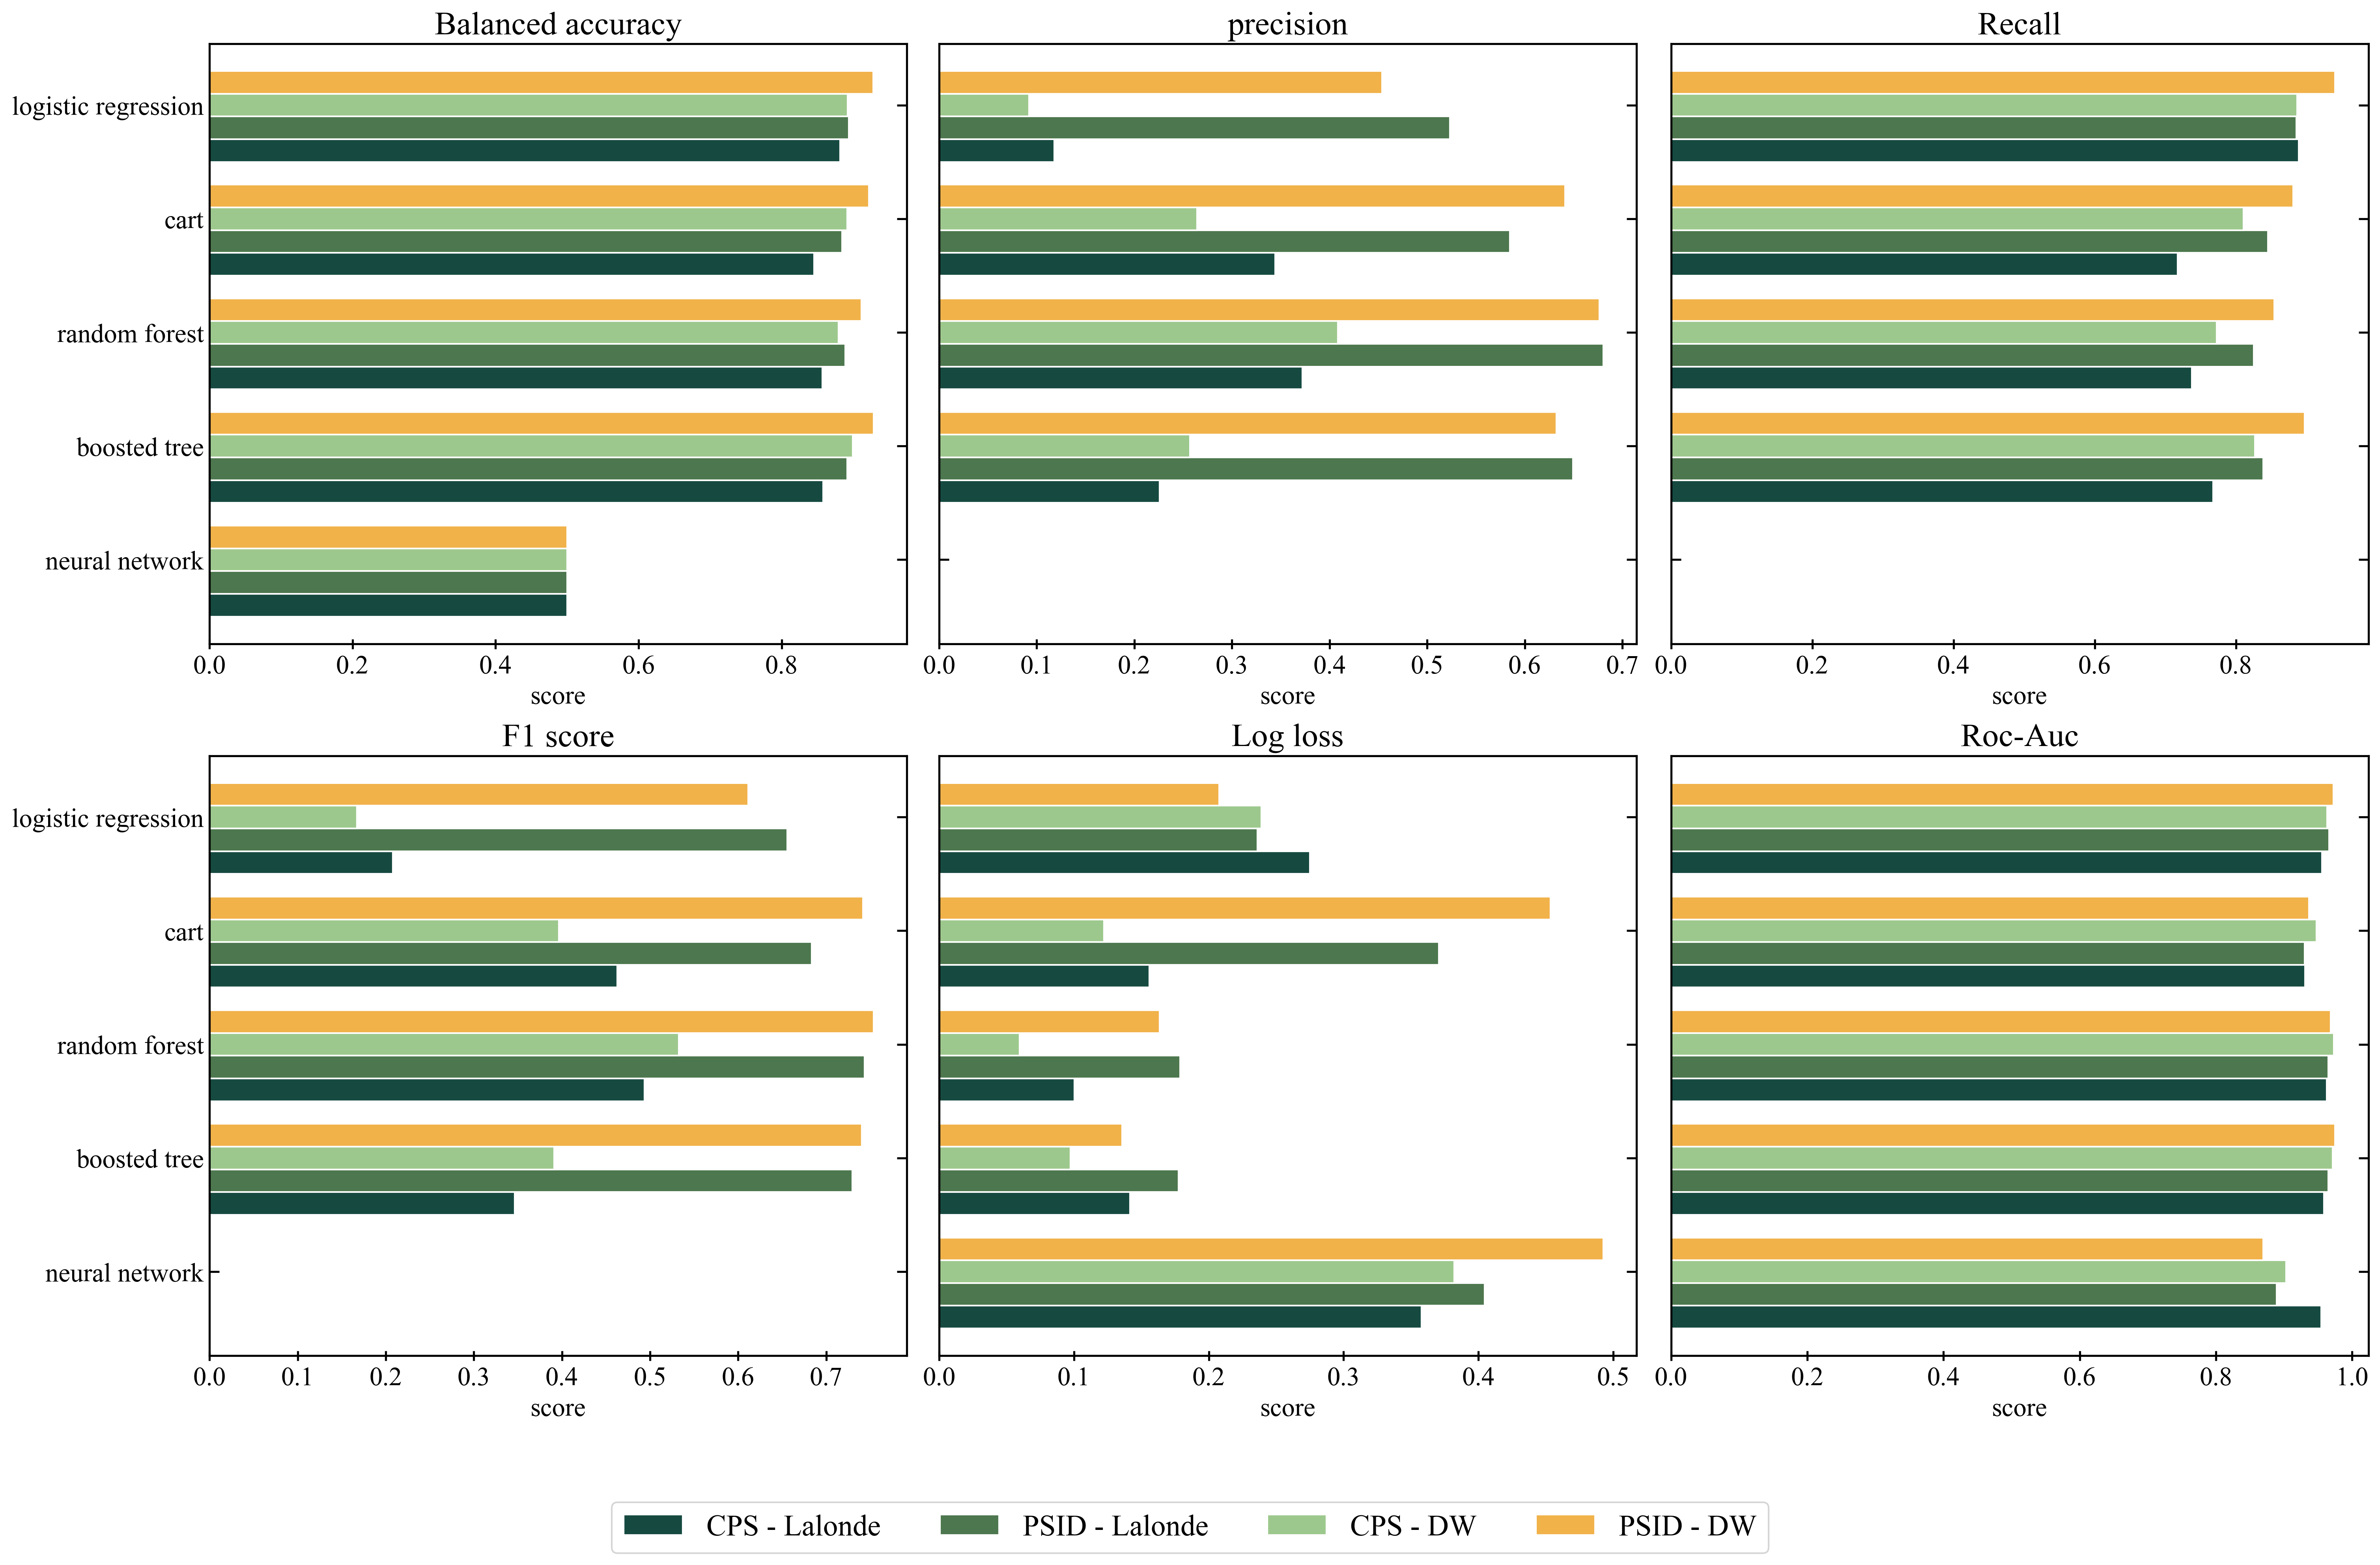

In [95]:
# Create plot 
# Update plot paramaters 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (20,12))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update({'font.size': 18})
y = np.arange(5)
x = np.arange(1)
width = 0.2
# Balanced accuracy

ax[0,0].set_title("Balanced accuracy",fontsize=20)
ax[0,0].set_xlabel('score',fontsize=16)
ax[0,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[0,0].tick_params(axis='x', which='major', labelsize=16)

colour1 = "#164A41" # CPS lalonde
colour2 = "#4D774E" # PSID lalonde
colour3 = "#9DC88D" # CPS dehwab
colour4 = "#F1B24A" # PSID dehwab

ax[0,0].barh(y,nsw_cps_lalonde_acc,width,color = colour1)
ax[0,0].barh(y+width,nsw_psid_lalonde_acc,width,color = colour2)
ax[0,0].barh(y+2*width,nsw_cps_dehWab_acc,width,color = colour3)
ax[0,0].barh(y+(3*width),nsw_psid_dehWab_acc,width,color = colour4)

ax[0,0].set_facecolor('white')
ax[0,0].grid(color='white', axis='y')
ax[0,0].grid(color='white', axis='x')
ax[0,0].spines['left']
ax[0,0].spines['right']
ax[0,0].spines['bottom']
ax[0,0].tick_params(right='on')
ax[0,0].tick_params(left='on')
ax[0,0].tick_params(bottom='on')

# precision

ax[0,1].set_title("precision",fontsize=20)
ax[0,1].set_xlabel('score',fontsize=16)
ax[0,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,1].tick_params(axis='x', which='major', labelsize=16)

ax[0,1].barh(y,nsw_cps_lalonde_prec,width,color = colour1)
ax[0,1].barh(y+width,nsw_psid_lalonde_prec,width,color = colour2)
ax[0,1].barh(y+2*width,nsw_cps_dehWab_prec,width,color = colour3)
ax[0,1].barh(y+(3*width),nsw_psid_dehWab_prec,width,color = colour4)

ax[0,1].set_facecolor('white')
ax[0,1].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].spines['left']
ax[0,1].spines['right']
ax[0,1].spines['bottom']
ax[0,1].tick_params(right='on')
ax[0,1].tick_params(left='on')
ax[0,1].tick_params(bottom='on')

# recall 

ax[0,2].set_title("Recall",fontsize=20)
ax[0,2].set_xlabel('score',fontsize=16)
ax[0,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,2].tick_params(axis='x', which='major', labelsize=16)

ax[0,2].barh(y,nsw_cps_lalonde_rec,width,color = colour1)
ax[0,2].barh(y+width,nsw_psid_lalonde_rec,width,color = colour2)
ax[0,2].barh(y+2*width,nsw_cps_dehWab_rec,width,color = colour3)
ax[0,2].barh(y+(3*width),nsw_psid_dehWab_rec,width,color = colour4)

ax[0,2].set_facecolor('white')
ax[0,2].grid(color='white', axis='y')
ax[0,2].grid(color='white', axis='x')
ax[0,2].spines['left']
ax[0,2].spines['right']
ax[0,2].spines['bottom']
ax[0,2].tick_params(right='on')
ax[0,2].tick_params(left='on')
ax[0,2].tick_params(bottom='on')

# F1
ax[1,0].set_title("F1 score",fontsize=20)
ax[1,0].set_xlabel('score',fontsize=16)
ax[1,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[1,0].tick_params(axis='x', which='major', labelsize=16)

ax[1,0].barh(y,nsw_cps_lalonde_f1,width,color = colour1)
ax[1,0].barh(y+width,nsw_psid_lalonde_f1,width,color = colour2)
ax[1,0].barh(y+2*width,nsw_cps_dehWab_f1,width,color = colour3)
ax[1,0].barh(y+(3*width),nsw_psid_dehWab_f1,width,color = colour4)

ax[1,0].set_facecolor('white')
ax[1,0].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].spines['left']
ax[1,0].spines['right']
ax[1,0].spines['bottom']
ax[1,0].tick_params(right='on')
ax[1,0].tick_params(left='on')
ax[1,0].tick_params(bottom='on')


# Log loss
ax[1,1].set_title("Log loss",fontsize=20)
ax[1,1].set_xlabel('score',fontsize=16)
ax[1,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,1].tick_params(axis='x', which='major', labelsize=16)

ax[1,1].barh(y,nsw_cps_lalonde_logloss,width,color = colour1)
ax[1,1].barh(y+width,nsw_psid_lalonde_logloss,width,color = colour2)
ax[1,1].barh(y+2*width,nsw_cps_dehWab_logloss,width,color = colour3)
ax[1,1].barh(y+(3*width),nsw_psid_dehWab_logloss,width,color = colour4)

ax[1,1].set_facecolor('white')
ax[1,1].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].spines['left']
ax[1,1].spines['right']
ax[1,1].spines['bottom']
ax[1,1].tick_params(right='on')
ax[1,1].tick_params(left='on')
ax[1,1].tick_params(bottom='on')

# Roc-AUC
ax[1,2].set_title("Roc-Auc",fontsize=20)
ax[1,2].set_xlabel('score',fontsize=16)
ax[1,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,2].tick_params(axis='x', which='major', labelsize=16)

ax[1,2].barh(y,nsw_cps_lalonde_rocauc,width,color = colour1)
ax[1,2].barh(y+width,nsw_psid_lalonde_rocauc,width,color = colour2)
ax[1,2].barh(y+2*width,nsw_cps_dehWab_rocauc,width,color = colour3)
ax[1,2].barh(y+(3*width),nsw_psid_dehWab_rocauc,width,color = colour4)

ax[1,2].set_facecolor('white')
ax[1,2].grid(color='white', axis='y')
ax[1,2].grid(color='white', axis='x')
ax[1,2].spines['left']
ax[1,2].spines['right']
ax[1,2].spines['bottom']
ax[1,2].tick_params(right='on')
ax[1,2].tick_params(left='on')
ax[1,2].tick_params(bottom='on')

labels = ['CPS - Lalonde','PSID - Lalonde','CPS - DW','PSID - DW']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/training_evaluation_averages_full_spec.png', bbox_inches='tight')
plt.show()

### Analysis on model outptus - Probability calibration curves 

In [24]:
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

In [25]:
from sklearn import tree      
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier    

In [26]:

# Take a random sample from the data with an even number of treated and control for testing

nswCps_lalonde_valid = nswCps_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_lalonde = nswCps_lalonde.drop(nswCps_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswPsid_lalonde_valid = nswPsid_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_lalonde = nswPsid_lalonde.drop(nswPsid_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswCps_dehWab_valid = nswCps_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_dehWab = nswCps_dehWab.drop(nswCps_dehWab_valid.index)# Remove all samples from training which are in the sample 

nswPsid_Dehwab_valid = nswPsid_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_dehWab = nswPsid_dehWab.drop(nswPsid_Dehwab_valid.index) # Remove all samples from training which are in the sample 

# covariates used in each mdoel 
logit_vars = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
logit_vars2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
tree_vars = ['treat','age','education*','black','hispanic','married','nodegree','re75']
tree_vars2 =   ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']

ann_vars = ['treat','ageboxcox','education*','black','hispanic','married','nodegree','re75'] 
ann_vars2 =['treat','ageboxcox','education*','black','hispanic','married','nodegree','re74','re75'] 
continuos_vars = ['ageboxcox','re75'] 
continuos_vars2= ['ageboxcox','re74','re75'] 
# ======== Lalonde - sample ======== #

# ~~~~~~~~~~
# 1 cps
# ~~~~~~~~~~

#logit model 
cps_lalonde_subset_logit = nswCps_lalonde[logit_vars]
cps_lalonde_subset_valid_logit = nswCps_lalonde_valid[logit_vars]
#decision tree models 
cps_lalonde_subset_trees = nswCps_lalonde[tree_vars]
cps_lalonde_subset_valid_trees = nswCps_lalonde_valid[tree_vars]
#ann model 
cps_lalonde_subset_ann = nswCps_lalonde[ann_vars]
cps_lalonde_subset_valid_ann = nswCps_lalonde_valid[ann_vars]
cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 2 PSID 
# ~~~~~~~~~~

#logit model 
psid_lalonde_subset_logit = nswPsid_lalonde[logit_vars]
psid_lalonde_subset_valid_logit = nswPsid_lalonde_valid[logit_vars]
#decision tree models 
psid_lalonde_subset_trees = nswPsid_lalonde[tree_vars]
psid_lalonde_subset_valid_trees = nswPsid_lalonde_valid[tree_vars]
#ann model 
psid_lalonde_subset_ann = nswPsid_lalonde[ann_vars]
psid_lalonde_subset_valid_ann = nswPsid_lalonde_valid[ann_vars]
psid_lalonde_subset_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_ann[continuos_vars])
psid_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_valid_ann[continuos_vars])


# ======== Dehejia - Wahba sample ======== #

# ~~~~~~~~~~
# 3 CPS
# ~~~~~~~~~~
# logit 
cps_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
cps_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
cps_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
cps_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
cps_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
cps_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
cps_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
cps_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 4 PSID
# ~~~~~~~~~~
# logit 
psid_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
psid_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
psid_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
psid_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
psid_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
psid_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
psid_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
psid_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_68455/1538135944.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_68455/1538135944.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn

In [27]:
# Function to run all models and get a prediction - using the best features from our grid search 
# Inputs are the dataset's we want to look at 


def fit_and_predict_all_models(logit_data,logit_valid,tree_data,tree_valid,ann_data,ann_valid,neuralnet):
    
    '''
    could make this function do all the smote and rejoing the validation set again sincce i am making my own, so there are more training examples
    
    '''
   
  
    
    #Train test split 
    def return_trainTest_split(Dataset):
        # shuffle data
        Dataset = Dataset.sample(frac = 1,random_state=0)
        Features = Dataset.drop('treat', axis=1)
        Target = Dataset['treat']
        X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test;

    
    resample=SMOTEENN(random_state=0) # resampling
    
    '''
    '''
    
    # Logit
    
    X_train1, X_test1, y_train1, y_test1 = return_trainTest_split(logit_data)
    X_train1, y_train1 = resample.fit_resample(X_train1, y_train1)	
    
    shuffled = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train1, y_train1 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
    
    logit_demo = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
    
    logit_demo.fit(X_train1,y_train1)
    
    logit_valid = logit_valid.sample(frac = 1,random_state=0)
    X_test1 = logit_valid.drop('treat',axis=1, inplace = False)
    y_test1 = logit_valid['treat']
    
    predicted_proba_logit = logit_demo.predict_proba(X_test1)
    
    
    
    # Decision tree models 
    
    X_train2, X_test2, y_train2, y_test2 = return_trainTest_split(tree_data)

    X_train2, y_train2 = resample.fit_resample(X_train2, y_train2)	
    shuffled = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train2, y_train2 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    tree_valid = tree_valid.sample(frac = 1,random_state=0)
    X_test2 = tree_valid.drop('treat',axis=1, inplace = False)
    y_test2 = tree_valid['treat']

    # Cart
    
    CART_demo = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5, max_leaf_nodes=12,min_samples_leaf=2)
    CART_demo.fit(X_train2,y_train2)
    predicted_proba_cart = CART_demo.predict_proba(X_test2)
    #RF
    forest_demo = RandomForestClassifier(random_state=0,criterion='entropy',max_depth=8,max_features='auto',min_samples_split=3,n_estimators=500)
    forest_demo.fit(X_train2,y_train2)
    predicted_proba_forest = forest_demo.predict_proba(X_test2)
    #boost
    boost_demo = XGBClassifier(objective= 'binary:logistic',booser='dart',colsample_bytree=0.3,gamma=0.5,learning_rate=0.05,mind_child_weight=1,subsample=0.5,seed=0,nthread=4)  
    boost_demo.fit(X_train2,y_train2)
    predicted_proba_boost = boost_demo.predict_proba(X_test2)

    #ANN
    X_train3, X_test3, y_train3, y_test3 = return_trainTest_split(ann_data)
    X_train3, y_train3 = resample.fit_resample(X_train3, y_train3)	
    shuffled = pd.concat([pd.DataFrame(X_train3),pd.DataFrame(y_train3)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train3, y_train3 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    ann_valid = ann_valid.sample(frac = 1,random_state=0)
    X_test3 = ann_valid.drop('treat',axis=1, inplace = False)
    y_test3 = ann_valid['treat']

    Epochs = 100
    learning_rate = 0.0001
    weight_decay = 0.05
    batch_size = 256

    X_train3 = X_train3.to_numpy()
    y_train3 = y_train3.to_numpy()
    X_train3 = X_train3.astype(np.float32)
    y_train3 = y_train3.astype(np.float32)
    y_train3 = np.reshape(y_train3,(y_train3.shape[0],1))

    X_test3 = X_test3.to_numpy()
    y_test3 = y_test3.to_numpy()
    X_test3 = X_test3.astype(np.float32)
    y_test3 = y_test3.astype(np.float32)
    y_test3 = np.reshape(y_test3,(y_test3.shape[0],1))

    ann_demo = NeuralNetClassifier(neuralnet,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False,verbose=0 )

    ann_demo.fit(X_train3,y_train3)
    predicted_proba_ANN = ann_demo.predict_proba(X_test3)
    
    return predicted_proba_logit,predicted_proba_cart,predicted_proba_forest,predicted_proba_boost,predicted_proba_ANN,y_test1,y_test2,y_test3;

    
    

In [28]:
logit_proba1,cart_proba1,forest_proba1,boost_proba1,ann_proba1,yl1,yt1,ya1 = fit_and_predict_all_models(cps_lalonde_subset_logit,
                                                                                            cps_lalonde_subset_valid_logit,
                                                                                            cps_lalonde_subset_trees,
                                                                                            cps_lalonde_subset_valid_trees,
                                                                                            cps_lalonde_subset_ann,
                                                                                            cps_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[09:34:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




: 

: 

In [ ]:
logit_proba2,cart_proba2,forest_proba2,boost_proba2,ann_proba2,yl2,yt2,ya2 = fit_and_predict_all_models(psid_lalonde_subset_logit,
                                                                                            psid_lalonde_subset_valid_logit,
                                                                                            psid_lalonde_subset_trees,
                                                                                            psid_lalonde_subset_valid_trees,
                                                                                            psid_lalonde_subset_ann,
                                                                                            psid_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

: 

: 

In [ ]:
logit_proba3,cart_proba3,forest_proba3,boost_proba3,ann_proba3,yl3,yt3,ya3 = fit_and_predict_all_models(cps_dehWab_subset_logit,
                                                                                            cps_dehWab_subset_valid_logit,
                                                                                            cps_dehWab_subset_trees,
                                                                                            cps_dehWab_subset_valid_trees,
                                                                                            cps_dehWab_subset_ann,
                                                                                            cps_dehWab_subset_valid_ann,
                                                                                            twoLayerNN3)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[01:54:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
logit_proba4,cart_proba4,forest_proba4,boost_proba4,ann_proba4,yl4,yt4,ya4 = fit_and_predict_all_models(psid_dehWab_subset_logit,
                                                                                            psid_dehWab_subset_valid_logit,
                                                                                            psid_dehWab_subset_trees,
                                                                                            psid_dehWab_subset_valid_trees,
                                                                                            psid_dehWab_subset_ann,
                                                                                            psid_dehWab_subset_valid_ann,
                                                                                            twoLayerNN4)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[01:54:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
# Calibration curve for each models prediction 
from sklearn.calibration import calibration_curve
logit_fop1  , logit_mpv1  = calibration_curve(yl1, logit_proba1[:,1], n_bins=10, normalize=True)
cart_fop1   , cart_mpv1   = calibration_curve(yt1, cart_proba1[:,1], n_bins=10, normalize=True)
forest_fop1  , forest_mpv1 = calibration_curve(yt1, forest_proba1[:,1], n_bins=10, normalize=True)
boost_fop1  , boost_mpv1  = calibration_curve(yt1, boost_proba1[:,1], n_bins=10, normalize=True)
ann_fop1    , ann_mpv1    = calibration_curve(ya1, ann_proba1, n_bins=10, normalize=True)

logit_fop2  , logit_mpv2  = calibration_curve(yl2, logit_proba2[:,1], n_bins=10, normalize=True)
cart_fop2   , cart_mpv2   = calibration_curve(yt2, cart_proba2[:,1], n_bins=10, normalize=True)
forest_fop2  , forest_mpv2 = calibration_curve(yt2, forest_proba2[:,1], n_bins=10, normalize=True)
boost_fop2  , boost_mpv2  = calibration_curve(yt2, boost_proba2[:,1], n_bins=10, normalize=True)
ann_fop2    , ann_mpv2    = calibration_curve(ya2, ann_proba2, n_bins=10, normalize=True)

logit_fop3  , logit_mpv3  = calibration_curve(yl3, logit_proba3[:,1], n_bins=10, normalize=True)
cart_fop3   , cart_mpv3   = calibration_curve(yt3, cart_proba3[:,1], n_bins=10, normalize=True)
forest_fop3  , forest_mpv3 = calibration_curve(yt3, forest_proba3[:,1], n_bins=10, normalize=True)
boost_fop3  , boost_mpv3  = calibration_curve(yt3, boost_proba3[:,1], n_bins=10, normalize=True)
ann_fop3    , ann_mpv3    = calibration_curve(ya3, ann_proba3, n_bins=10, normalize=True)

logit_fop4  , logit_mpv4  = calibration_curve(yl4, logit_proba4[:,1], n_bins=10, normalize=True)
cart_fop4   , cart_mpv4   = calibration_curve(yt4, cart_proba4[:,1], n_bins=10, normalize=True)
forest_fop4  , forest_mpv4 = calibration_curve(yt4, forest_proba4[:,1], n_bins=10, normalize=True)
boost_fop4  , boost_mpv4  = calibration_curve(yt4, boost_proba4[:,1], n_bins=10, normalize=True)
ann_fop4    , ann_mpv4    = calibration_curve(ya4, ann_proba4, n_bins=10, normalize=True)


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


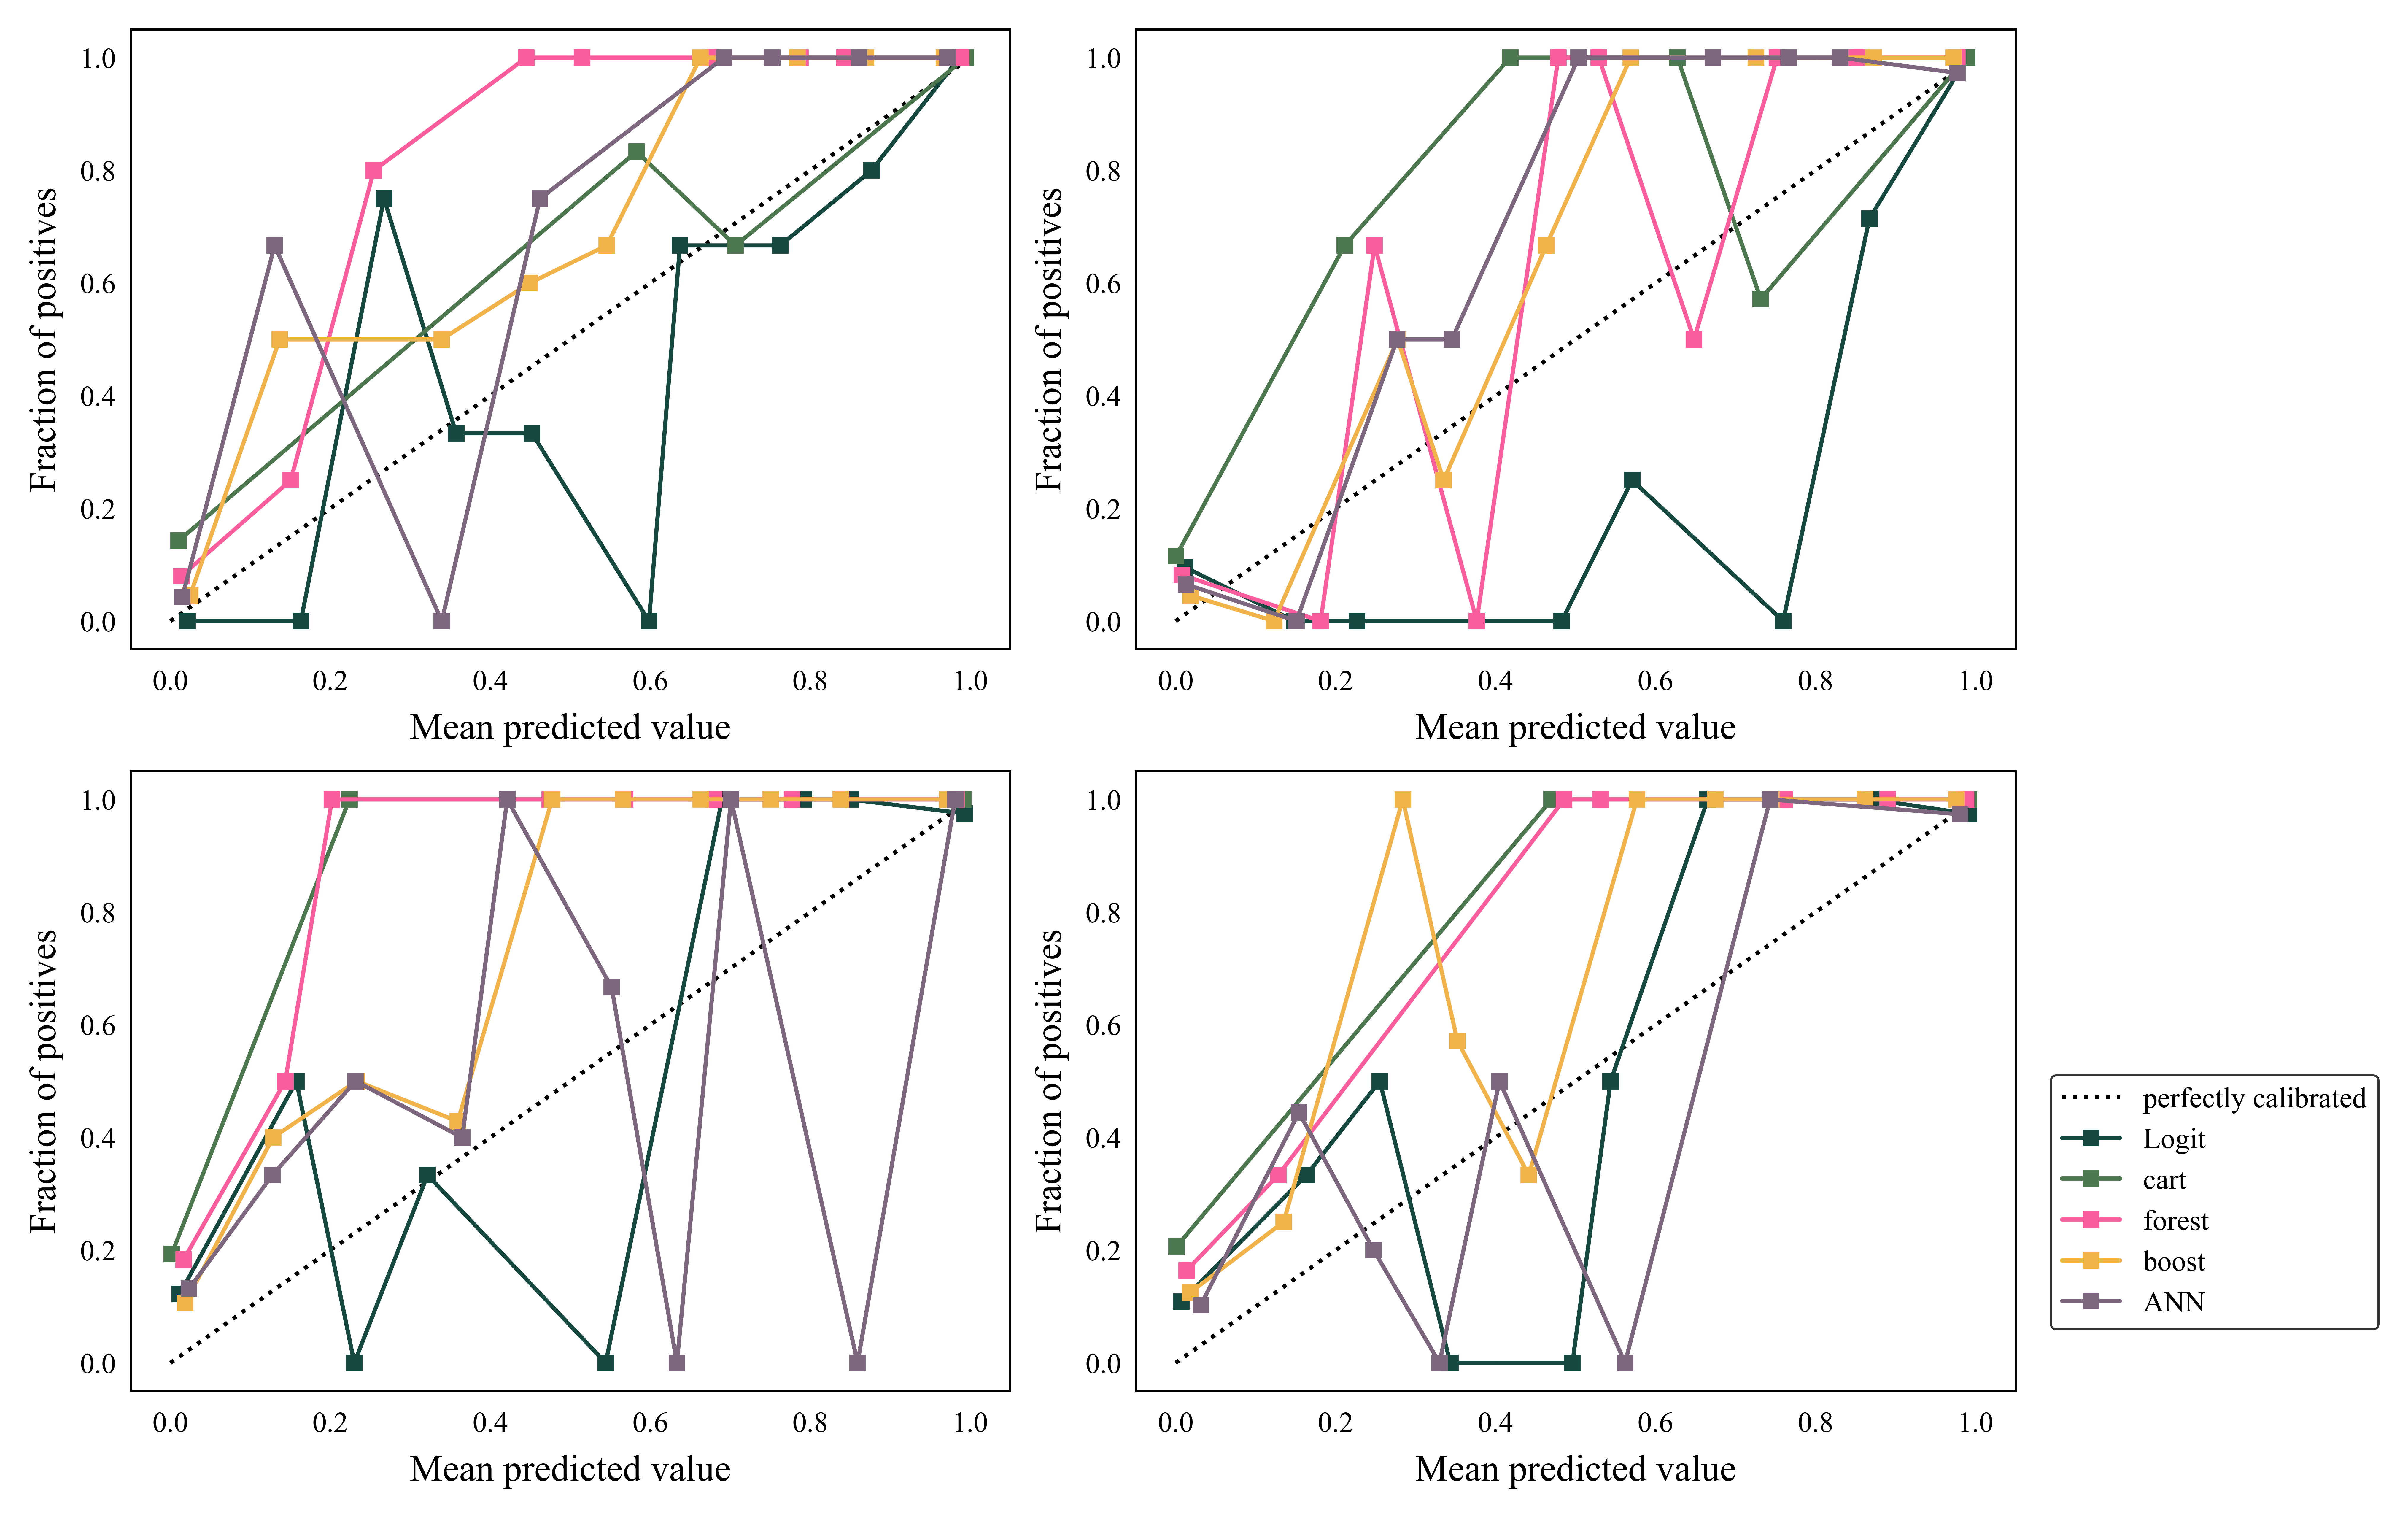

In [106]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (8,5))

plt.rcParams.update({"figure.dpi": 1000}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(axes.lines())


ax[0,0].grid(color='white', axis='x')
ax[0,0].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].grid(color='white', axis='y')

colour_1 = "#164A41"
colour_2 = "#4D774E"
colour_3 = "#f95d9b"
colour_4 = "#F1B24A"
colour_5 =   "#7c677f"

marker = 's'
linewidth = 1
marker_size = 3

ax[0,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,0].plot(logit_mpv1  , logit_fop1 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[0,0].plot(cart_mpv1   , cart_fop1, marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[0,0].plot(forest_mpv1 , forest_fop1,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[0,0].plot(boost_mpv1  , boost_fop1,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[0,0].plot(ann_mpv1    , ann_fop1 ,marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[0,0].set_xlabel('Mean predicted value')
ax[0,0].set_ylabel('Fraction of positives')

ax[0,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,1].plot(logit_mpv2  , logit_fop2 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[0,1].plot(cart_mpv2   , cart_fop2  , marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[0,1].plot(forest_mpv2 , forest_fop2 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[0,1].plot(boost_mpv2  , boost_fop2  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[0,1].plot(ann_mpv2    , ann_fop2    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[0,1].set_xlabel('Mean predicted value')
ax[0,1].set_ylabel('Fraction of positives')

ax[1,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[1,0].plot(logit_mpv3  , logit_fop3  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[1,0].plot(cart_mpv3   , cart_fop3   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[1,0].plot(forest_mpv3 , forest_fop3 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[1,0].plot(boost_mpv3  , boost_fop3  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[1,0].plot(ann_mpv3    , ann_fop3    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[1,0].set_xlabel('Mean predicted value')
ax[1,0].set_ylabel('Fraction of positives')

ax[1,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=linewidth,color='black')
ax[1,1].plot(logit_mpv4  , logit_fop4  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size, color = colour_1 )
ax[1,1].plot(cart_mpv4   , cart_fop4   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size, color = colour_2 )
ax[1,1].plot(forest_mpv4 , forest_fop4 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size, color = colour_3 )
ax[1,1].plot(boost_mpv4  , boost_fop4  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size, color = colour_4 )
ax[1,1].plot(ann_mpv4    , ann_fop4    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size, color = colour_5 )
ax[1,1].set_xlabel('Mean predicted value')
ax[1,1].set_ylabel('Fraction of positives')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/calibration_curve_full_spec.png', bbox_inches='tight')

plt.legend(loc=(1.04, 0.1))
plt.show()

## Box plots